In [1]:
# --- Setup and Configuration ---
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import mstats
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from google.oauth2 import service_account
from google.cloud import bigquery
import pandas_gbq
import kagglehub


In [2]:
# --- 1. Data Download (Kaggle) - With Error Handling and Installation Check ---
import kagglehub


path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")  # Descargar dataset de Kaggle

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Manuel\.cache\kagglehub\datasets\olistbr\brazilian-ecommerce\versions\2


In [3]:
# --- 2. Data Loading (Pandas) ---

files = os.listdir(path)
csv_files = [f for f in files if f.endswith('.csv')]
dataframes = {}

for file in csv_files:
    file_path = os.path.join(path, file)
    df_name = os.path.splitext(file)[0]
    try:
        dataframes[df_name] = pd.read_csv(file_path, encoding='utf-8')
    except UnicodeDecodeError:
        try:
            dataframes[df_name] = pd.read_csv(file_path, encoding='latin-1')
        except Exception as e:
            print(f"Error reading file {file}: {e}")
            continue  # Skip to the next file

    print(f"DataFrame: {df_name}")  # Show DataFrame name
    if 'order_id' in dataframes[df_name].columns:
        print("  - Contains order_id")
    if 'customer_id' in dataframes[df_name].columns:
        print("  - Contains customer_id")
    if 'product_id' in dataframes[df_name].columns:
        print("  - Contains product_id")



DataFrame: olist_customers_dataset
  - Contains customer_id
DataFrame: olist_geolocation_dataset
DataFrame: olist_orders_dataset
  - Contains order_id
  - Contains customer_id
DataFrame: olist_order_items_dataset
  - Contains order_id
  - Contains product_id
DataFrame: olist_order_payments_dataset
  - Contains order_id
DataFrame: olist_order_reviews_dataset
  - Contains order_id
DataFrame: olist_products_dataset
  - Contains product_id
DataFrame: olist_sellers_dataset
DataFrame: product_category_name_translation


In [4]:
# --- 3. BigQuery Setup ---
# Use environment variable for credentials (BEST PRACTICE)
credentials_path = os.environ.get('GOOGLE_APPLICATION_CREDENTIALS')

if credentials_path:
    bq_cred = service_account.Credentials.from_service_account_file(credentials_path)
else:
    print("Error: GOOGLE_APPLICATION_CREDENTIALS environment variable not set.")
    exit()  # Exit if credentials aren't set

project_id = 'tactical-hydra-440201-p5'  # Replace with your actual project ID
dataset_id = f'{project_id}.olistbr_brazilian_ecommerce'

client = bigquery.Client(project=project_id, credentials=bq_cred)

# Create the dataset if it doesn't exist
try:
    dataset = bigquery.Dataset(dataset_id)
    dataset.location = 'US'  # Or your preferred location
    dataset = client.create_dataset(dataset, exists_ok=True)
    print(f"Dataset {dataset_id} created or already exists.")
except Exception as e:
     print(f"Error: to create Dataset, {e}")

Dataset tactical-hydra-440201-p5.olistbr_brazilian_ecommerce created or already exists.


In [6]:
# --- 4. Upload Data to BigQuery ---

for table_id, df in dataframes.items():
    destination_table = f'olistbr_brazilian_ecommerce.{table_id}'
    try:
        pandas_gbq.to_gbq(
            df,
            destination_table=destination_table,
            project_id=project_id,
            if_exists='replace',  # Replace the table if it already exists
            credentials=bq_cred
        )
        print(f"Table {destination_table} uploaded successfully.")
    except Exception as e:
        print(f"Error uploading table {table_id}: {e}")


100%|██████████| 1/1 [00:00<?, ?it/s]


Table olistbr_brazilian_ecommerce.olist_customers_dataset uploaded successfully.


100%|██████████| 1/1 [00:00<?, ?it/s]


Table olistbr_brazilian_ecommerce.olist_geolocation_dataset uploaded successfully.


100%|██████████| 1/1 [00:00<?, ?it/s]


Table olistbr_brazilian_ecommerce.olist_orders_dataset uploaded successfully.


100%|██████████| 1/1 [00:00<?, ?it/s]


Table olistbr_brazilian_ecommerce.olist_order_items_dataset uploaded successfully.


100%|██████████| 1/1 [00:00<?, ?it/s]


Table olistbr_brazilian_ecommerce.olist_order_payments_dataset uploaded successfully.


100%|██████████| 1/1 [00:00<?, ?it/s]


Table olistbr_brazilian_ecommerce.olist_order_reviews_dataset uploaded successfully.


100%|██████████| 1/1 [00:00<?, ?it/s]


Table olistbr_brazilian_ecommerce.olist_products_dataset uploaded successfully.


100%|██████████| 1/1 [00:00<?, ?it/s]


Table olistbr_brazilian_ecommerce.olist_sellers_dataset uploaded successfully.


100%|██████████| 1/1 [00:00<?, ?it/s]

Table olistbr_brazilian_ecommerce.product_category_name_translation uploaded successfully.


C:\Users\Manuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


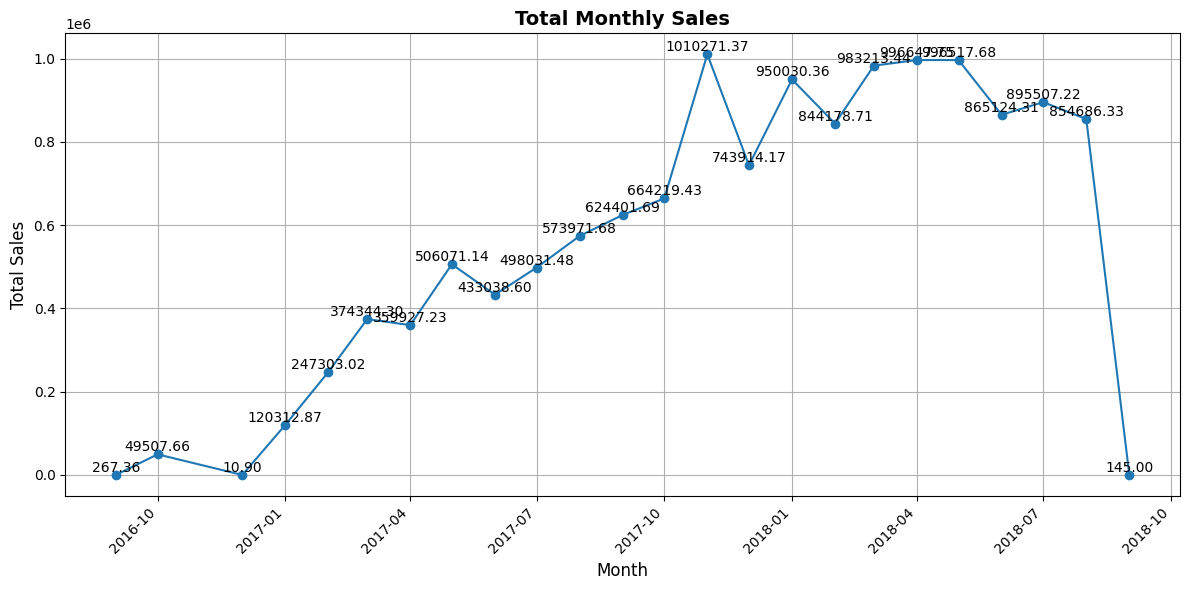

In [8]:
# --- 5. Data Analysis (SQL Queries and Visualizations) ---

# --- 5.1. Monthly Sales ---

query_monthly_sales = f"""
    SELECT
        DATE_TRUNC(PARSE_TIMESTAMP('%Y-%m-%d %H:%M:%S', o.order_purchase_timestamp), MONTH) AS month,
        SUM(oi.price) AS total_sales
    FROM
        `{project_id}.olistbr_brazilian_ecommerce.olist_order_items_dataset` AS oi
    JOIN
        `{project_id}.olistbr_brazilian_ecommerce.olist_orders_dataset` AS o
        ON oi.order_id = o.order_id
    GROUP BY
        month
    ORDER BY
        month
    """

monthly_sales = client.query(query_monthly_sales).to_dataframe()

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['month'], monthly_sales['total_sales'], marker='o')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.title('Total Monthly Sales', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
for x, y in zip(monthly_sales['month'], monthly_sales['total_sales']):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')  # Add data labels
plt.tight_layout()
plt.show()

C:\Users\Manuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


<Figure size 1200x600 with 0 Axes>

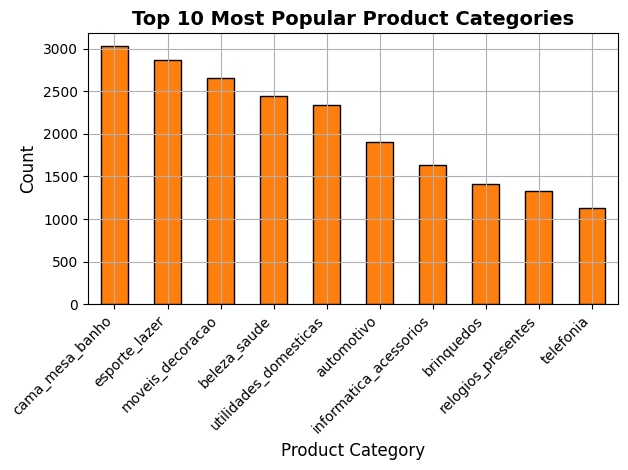

In [10]:
# --- 5.2. Top 10 Product Categories ---

query_top_categories = f"""
    SELECT
        product_category_name,
        COUNT(*) AS count
    FROM
        `{project_id}.olistbr_brazilian_ecommerce.olist_products_dataset`
    GROUP BY
        product_category_name
    ORDER BY
        count DESC
    LIMIT 10
    """

top_categories_df = client.query(query_top_categories).to_dataframe()

plt.figure(figsize=(12, 6))
colors = plt.cm.tab10.colors
top_categories_df.plot(kind='bar', x='product_category_name', y='count', color=colors[1], edgecolor='black', legend=False)
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Top 10 Most Popular Product Categories', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\Manuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


<Figure size 800x800 with 0 Axes>

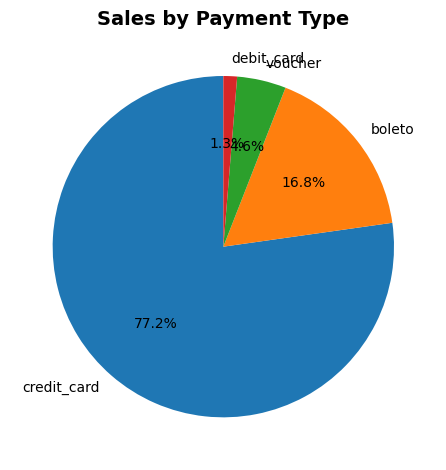

In [14]:
# --- 5.3. Sales by Payment Type ---

query_sales_by_payment = f"""
    SELECT
        payment_type,
        SUM(price) AS total_sales
    FROM
        `{project_id}.olistbr_brazilian_ecommerce.olist_order_payments_dataset` AS op
    JOIN
        `{project_id}.olistbr_brazilian_ecommerce.olist_order_items_dataset` AS oi
        ON op.order_id = oi.order_id
    GROUP BY
        payment_type
    ORDER BY
        total_sales DESC
    """

sales_by_payment_df = client.query(query_sales_by_payment).to_dataframe()

plt.figure(figsize=(8, 8))
sales_by_payment_df.set_index('payment_type').plot(kind='pie', y='total_sales', autopct='%1.1f%%', startangle=90, legend=False, colors=plt.cm.tab10.colors)
plt.ylabel('')
plt.title('Sales by Payment Type', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

C:\Users\Manuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


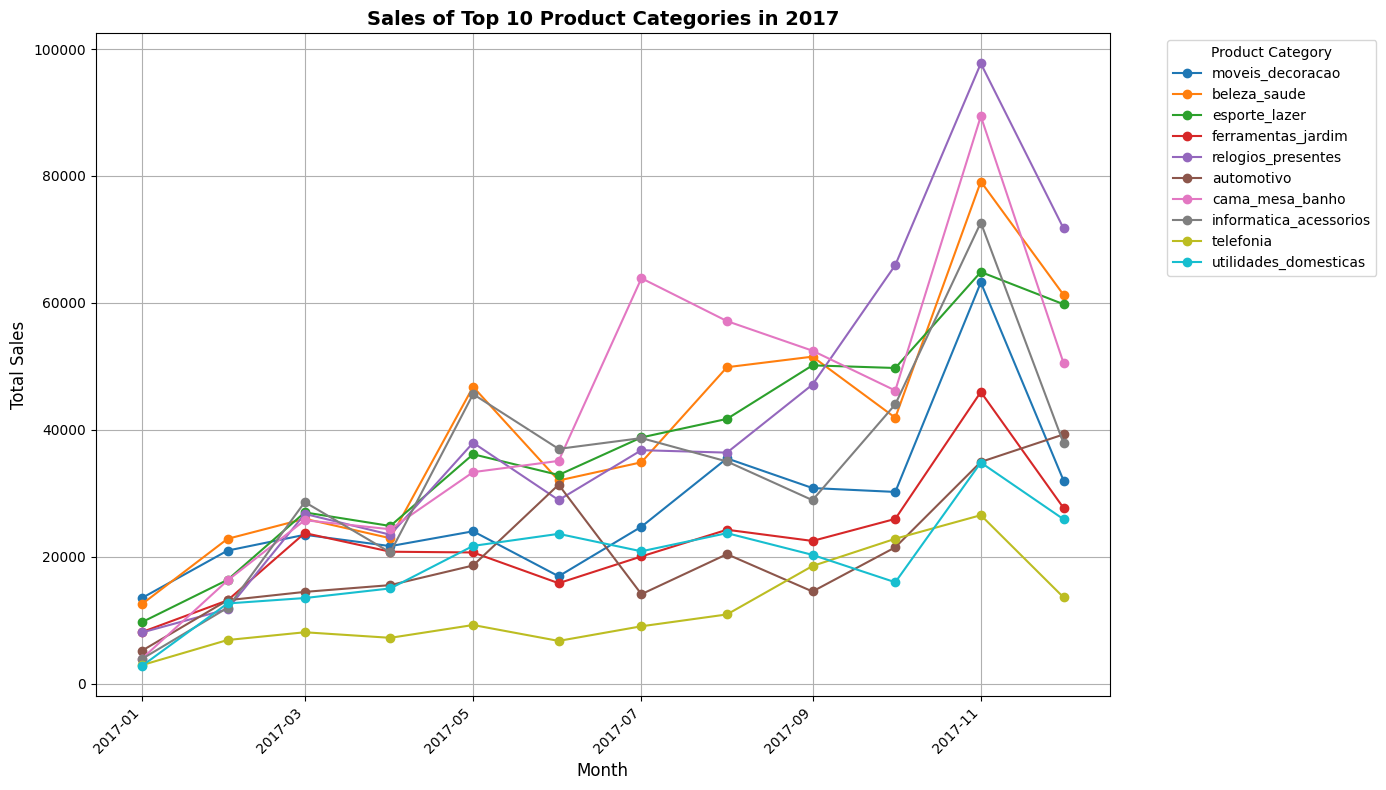

In [16]:
# --- 5.4. Top Products Trends in 2017 ---

query_top_products_trends = f"""
    WITH top_products AS (
        SELECT
            p.product_category_name,
            COUNT(*) AS count
        FROM
            `{project_id}.olistbr_brazilian_ecommerce.olist_order_items_dataset` AS oi
        JOIN
            `{project_id}.olistbr_brazilian_ecommerce.olist_products_dataset` AS p
            ON oi.product_id = p.product_id
        GROUP BY
            p.product_category_name
        ORDER BY
            count DESC
        LIMIT 10
    ),
    monthly_sales AS (
        SELECT
            DATE_TRUNC(PARSE_TIMESTAMP('%Y-%m-%d %H:%M:%S', o.order_purchase_timestamp), MONTH) AS month,
            p.product_category_name,
            SUM(oi.price) AS total_sales
        FROM
            `{project_id}.olistbr_brazilian_ecommerce.olist_order_items_dataset` AS oi
        JOIN
            `{project_id}.olistbr_brazilian_ecommerce.olist_orders_dataset` AS o
            ON oi.order_id = o.order_id
        JOIN
            `{project_id}.olistbr_brazilian_ecommerce.olist_products_dataset` AS p
            ON oi.product_id = p.product_id
        WHERE
            EXTRACT(YEAR FROM PARSE_TIMESTAMP('%Y-%m-%d %H:%M:%S', o.order_purchase_timestamp)) = 2017
        GROUP BY
            month, p.product_category_name
    )
    SELECT
        ms.month,
        ms.product_category_name,
        ms.total_sales
    FROM
        monthly_sales AS ms
    JOIN
        top_products AS tp
        ON ms.product_category_name = tp.product_category_name
    ORDER BY
        ms.month, ms.total_sales DESC
    """

top_products_trends_df = client.query(query_top_products_trends).to_dataframe()

plt.figure(figsize=(14, 8))
for category in top_products_trends_df['product_category_name'].unique():
    category_data = top_products_trends_df[top_products_trends_df['product_category_name'] == category]
    plt.plot(category_data['month'], category_data['total_sales'], marker='o', label=category)

plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.title('Sales of Top 10 Product Categories in 2017', fontsize=14, fontweight='bold')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
# --- 5.5. Sales by State ---
query_sales_by_state = f"""
SELECT
    c.customer_state,
    SUM(oi.price) AS total_sales,
    COUNT(DISTINCT o.order_id) AS total_orders,
    COUNT(DISTINCT c.customer_id) AS total_customers
FROM
    `{project_id}.olistbr_brazilian_ecommerce.olist_order_items_dataset` AS oi
JOIN
    `{project_id}.olistbr_brazilian_ecommerce.olist_orders_dataset` AS o
    ON oi.order_id = o.order_id
JOIN
    `{project_id}.olistbr_brazilian_ecommerce.olist_customers_dataset` AS c
    ON o.customer_id = c.customer_id
GROUP BY
    c.customer_state
ORDER BY
    total_sales DESC
"""
sales_by_state_df = client.query(query_sales_by_state).to_dataframe()
print(sales_by_state_df)


C:\Users\Manuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


   customer_state   total_sales  total_orders  total_customers
0              SP  5.202955e+06         41375            41375
1              RJ  1.824093e+06         12762            12762
2              MG  1.585308e+06         11544            11544
3              RS  7.503040e+05          5432             5432
4              PR  6.830838e+05          4998             4998
5              SC  5.205533e+05          3612             3612
6              BA  5.113500e+05          3358             3358
7              DF  3.026039e+05          2125             2125
8              GO  2.945919e+05          2007             2007
9              ES  2.750373e+05          2025             2025
10             PE  2.627880e+05          1648             1648
11             CE  2.272547e+05          1327             1327
12             PA  1.789478e+05           970              970
13             MT  1.564535e+05           903              903
14             MA  1.196482e+05           740          

<Figure size 1200x600 with 0 Axes>

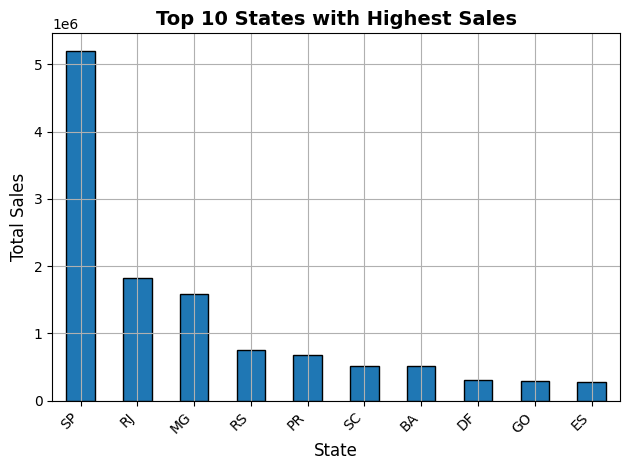

In [19]:
# --- 5.6. Top 10 States by Sales (Visualization) ---
top_10_states = sales_by_state_df.head(10)

plt.figure(figsize=(12, 6))
top_10_states.plot(kind='bar', x='customer_state', y='total_sales', color=plt.cm.tab10.colors[0], edgecolor='black', legend=False)
plt.xlabel('State', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.title('Top 10 States with Highest Sales', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
# --- 6. Data Preparation for CLV and Clustering ---

# Merge DataFrames
orders_items_customers = pd.merge(
    pd.merge(dataframes['olist_order_items_dataset'], dataframes['olist_orders_dataset'], on='order_id'),
    dataframes['olist_customers_dataset'],
    on='customer_id'
)
# Calculate number of purchases per customer
purchases_per_customer = orders_items_customers.groupby('customer_unique_id').agg(total_purchases=('order_id', 'nunique')).reset_index()

# Calculate 'real_sale' (price - freight_value)
orders_items_customers['real_sale'] = orders_items_customers['price'] - orders_items_customers['freight_value']

# Calculate Average Order Value (AOV)
aov = orders_items_customers.groupby('customer_unique_id')['real_sale'].mean().reset_index()
aov.rename(columns={'real_sale': 'AOV'}, inplace=True)

# Merge purchases and AOV
clv_data = purchases_per_customer.merge(aov, on='customer_unique_id', how='left')

# Calculate Customer Lifetime Value (CLV) -  Simplified Formula
clv_data['CLV'] = clv_data['total_purchases'] * clv_data['AOV']

# Merge with customer demographic data (optional, for further analysis)
customer_data = clv_data.merge(dataframes['olist_customers_dataset'][['customer_unique_id', 'customer_city']], on='customer_unique_id', how='left')



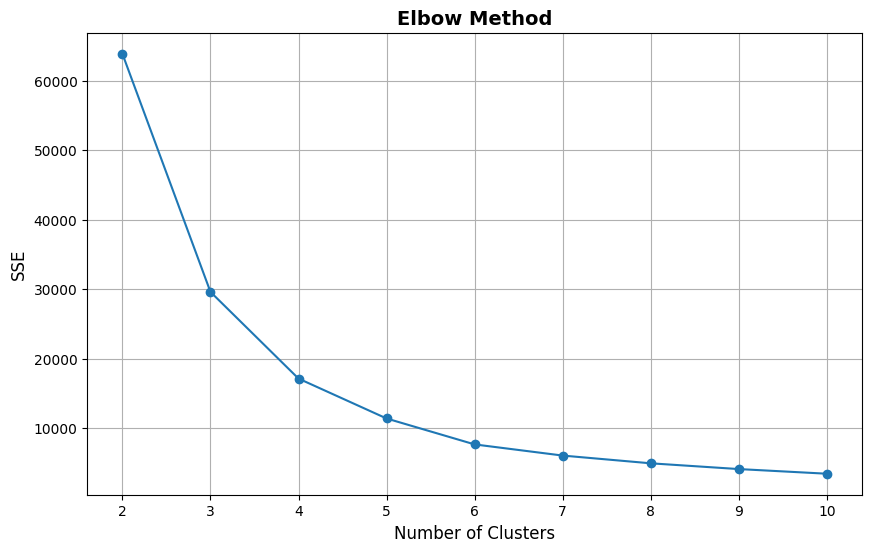

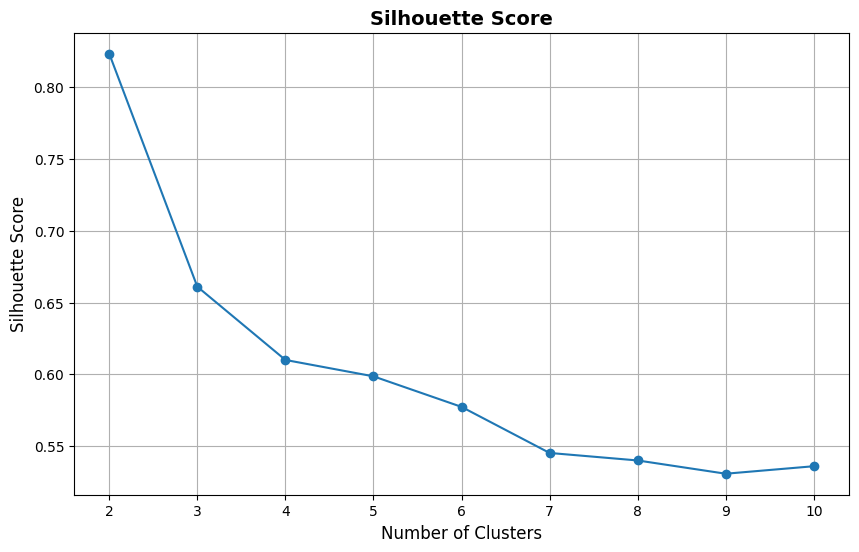

In [21]:
# --- 7. Customer Segmentation (K-Means Clustering) ---

# Prepare data for clustering
comparison_df = customer_data.groupby('customer_unique_id')[['CLV', 'AOV']].first().reset_index() # Using AOV instead of Profit.Avg

# Handle outliers (Winsorizing)
for col in ['CLV', 'AOV']:
    comparison_df[f'{col}_winsorized'] = mstats.winsorize(comparison_df[col], limits=[0.01, 0.01])

# Scale data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(comparison_df[['CLV_winsorized', 'AOV_winsorized']])

# Determine optimal number of clusters (Elbow Method and Silhouette Score)
sse = []
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    kmeans.fit(data_scaled)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_scaled, kmeans.labels_))

# Plot Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), sse, marker='o')
plt.title('Elbow Method', fontsize=14, fontweight='bold')
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('SSE', fontsize=12)
plt.grid(True)
plt.show()

# Plot Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score', fontsize=14, fontweight='bold')
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(True)
plt.show()

In [22]:
# --- 7.1 Choose Optimal k and Train Final K-Means Model ---
n_clusters = 4  #  Choose based on Elbow and Silhouette plots
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=30)
kmeans.fit(data_scaled)
comparison_df['Cluster'] = kmeans.labels_

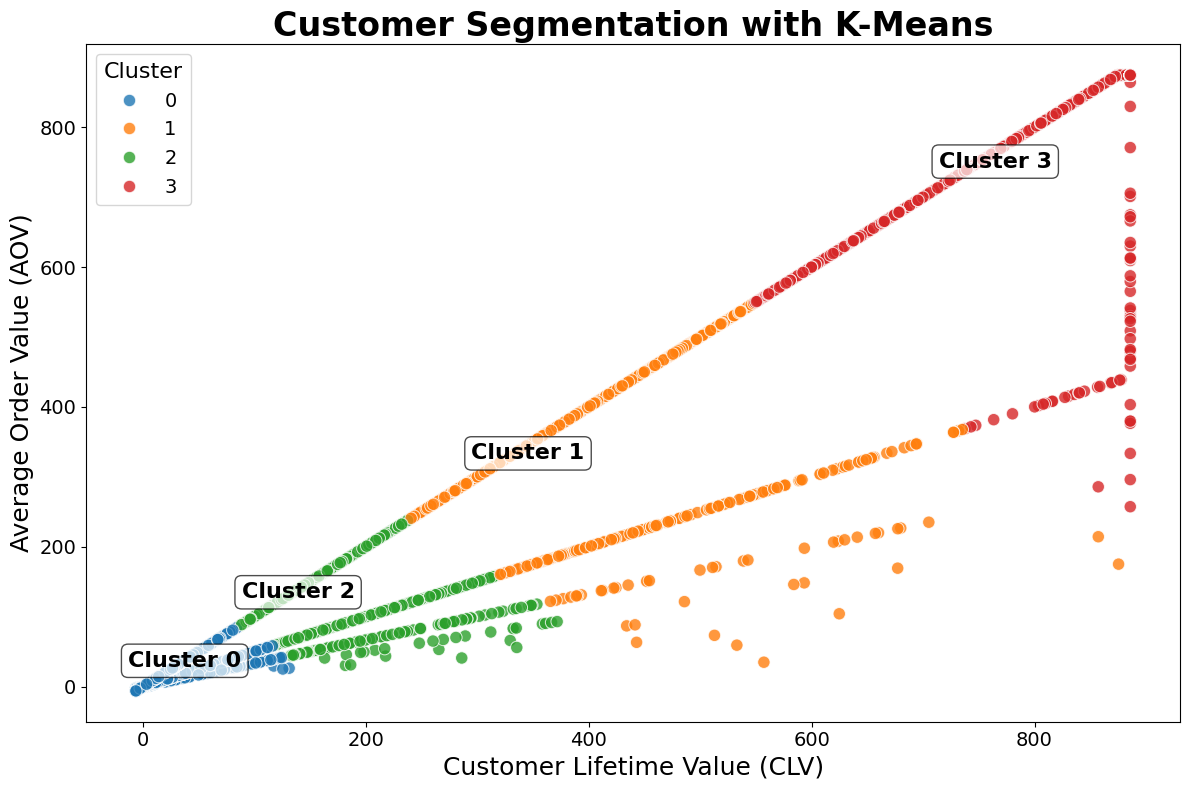

In [23]:
# --- 7.2 Visualize Clusters (Improved Plot) ---
plt.figure(figsize=(12, 8))
sns.scatterplot(x='CLV_winsorized', y='AOV_winsorized', hue='Cluster',
                data=comparison_df, palette='tab10', alpha=0.8, s=80, legend='full')
plt.title('Customer Segmentation with K-Means', fontsize=24, fontweight='bold')
plt.xlabel('Customer Lifetime Value (CLV)', fontsize=18)
plt.ylabel('Average Order Value (AOV)', fontsize=18)
plt.legend(title='Cluster', fontsize=14, title_fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Remove gridlines (optional, for cleaner look on social media)
plt.grid(False)

# Add annotations (optional, but can be very helpful for storytelling)
# Example: Annotate the center of each cluster
centroids = kmeans.cluster_centers_
# Need to inverse transform the centroids to the original scale
centroids_original_scale = scaler.inverse_transform(centroids)

for i in range(n_clusters):
    plt.text(centroids_original_scale[i, 0], centroids_original_scale[i, 1],
             f'Cluster {i}',  # Text to display
             fontsize=16,
             fontweight='bold',
             color='black',  #  Text color
             ha='center',  # Horizontal alignment
             va='center',   # Vertical alignment
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round,pad=0.3')) # Add a box

# You could also annotate specific, interesting data points (as before, but updated for AOV):
#  Find the customer with the highest CLV in Cluster 2 (for example)
#  high_clv_customer = comparison_df[(comparison_df['Cluster'] == 2)].nlargest(1, 'CLV_winsorized')
#  plt.annotate("High CLV Customer",
#               xy=(high_clv_customer['CLV_winsorized'].values[0], high_clv_customer['AOV_winsorized'].values[0]),
#               xytext=(high_clv_customer['CLV_winsorized'].values[0] + 1000, high_clv_customer['AOV_winsorized'].values[0] + 50), # Adjust positioning
#               arrowprops=dict(facecolor='black', shrink=0.05),
#               fontsize=12)

# Display and save (high resolution for social media/presentations)
plt.tight_layout()  # Adjust layout to prevent labels from being cut off
plt.savefig("customer_segmentation_plot_final.png", dpi=300)  # Save as high-res PNG
plt.show()


In [24]:
# --- 8. Cluster Analysis and Interpretation ---

# 8.1. Summary Statistics per Cluster
cluster_summary = comparison_df.groupby('Cluster').agg({
    'CLV_winsorized': ['mean', 'median', 'std', 'min', 'max'],
    'AOV_winsorized': ['mean', 'median', 'std', 'min', 'max']
})
print("\nCluster Summary Statistics:")
print(cluster_summary)


Cluster Summary Statistics:
        CLV_winsorized                                      AOV_winsorized  \
                  mean   median         std     min     max           mean   
Cluster                                                                      
0            37.640886   35.380   25.599734   -6.23  131.30      36.915454   
1           345.525553  322.875   87.554526  238.36  875.42     333.411115   
2           139.421766  130.120   41.021115   87.16  371.74     134.960674   
3           764.604037  800.120  124.546838  548.58  885.93     750.642665   

                                              
         median         std      min     max  
Cluster                                       
0         34.80   24.974522   -6.230   87.15  
1        314.53   86.315759   34.825  548.52  
2        126.14   38.896743   30.300  238.29  
3        779.63  127.982512  257.245  874.46  


## Cluster Analysis and Interpretation

The K-Means clustering algorithm (with k=4) identified four distinct customer segments based on Customer Lifetime Value (CLV) and Average Order Value (AOV).  The following table summarizes the key statistics for each cluster:

[Insert your `cluster_summary` table here - the output of `print(cluster_summary)`]

The following bar charts visualize the average CLV and AOV for each cluster:

[Insert your bar chart visualizations here - the output of `plt.show()` for the CLV and AOV bar charts]

### Cluster Interpretations and Recommendations

**Cluster 0: Low Value, Low AOV**

*   **Description:** This is the lowest-value customer segment, with both low CLV and low AOV.  The mean CLV is [insert mean CLV], and the mean AOV is [insert mean AOV].  This indicates that customers in this group make small, infrequent purchases.
*   **Recommendations:**
    *   Investigate the reasons for low profitability (product categories, regions, discounts).
    *   Consider strategies to increase spending (e.g., minimum order value, targeted promotions).
    *   If profitability cannot be improved, consider disengaging from this segment.

**Cluster 1: Moderate Value, Moderate AOV**

*   **Description:** ... [Explain Cluster 1 in a similar way] ...
*   **Recommendations:** ...

**Cluster 2: Low-Moderate Value, Low-Moderate AOV**

*   **Description:** ... [Explain Cluster 2] ...
*   **Recommendations:** ...

**Cluster 3: High Value, High AOV**

*   **Description:** ... [Explain Cluster 3] ...
*   **Recommendations:** ...

## Conclusion

The analysis reveals four distinct customer segments, highlighting a clear need for targeted strategies: addressing losses in Cluster 0, nurturing growth in Clusters 1 and 2, and retaining the high-value customers in Cluster 3.

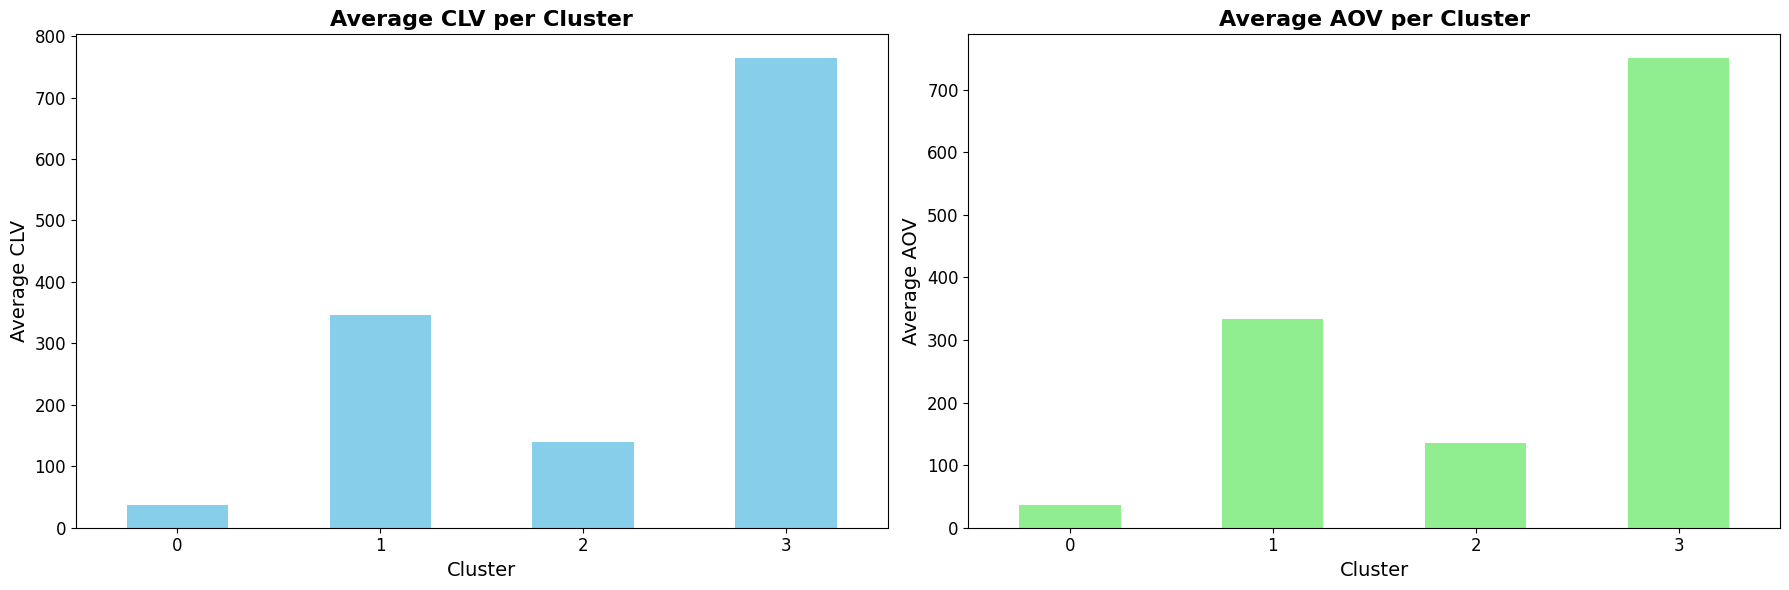

In [25]:
# 8.2. Visualize Mean CLV and AOV per Cluster (Bar Charts)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # Create subplots

# Average CLV per Cluster
cluster_summary['CLV_winsorized']['mean'].plot(kind='bar', ax=axes[0], color='skyblue', rot=0)
axes[0].set_title('Average CLV per Cluster', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Cluster', fontsize=14)
axes[0].set_ylabel('Average CLV', fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12) #set size

# Average AOV per Cluster
cluster_summary['AOV_winsorized']['mean'].plot(kind='bar', ax=axes[1], color='lightgreen', rot=0)
axes[1].set_title('Average AOV per Cluster', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Cluster', fontsize=14)
axes[1].set_ylabel('Average AOV', fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=12) #set size

plt.tight_layout()
plt.savefig("clv_aov_by_cluster.png", dpi=300)
plt.show()



Category Distribution by Cluster:
product_category_name_english  agro_industry_and_commerce  air_conditioning  \
Cluster                                                                       
0                                                0.001170          0.001588   
1                                                0.011840          0.003996   
2                                                0.000769          0.004548   
3                                                0.009653          0.007722   

product_category_name_english       art  arts_and_craftmanship     audio  \
Cluster                                                                    
0                              0.001895               0.000209  0.002996   
1                              0.000148               0.000148  0.005032   
2                              0.002374               0.000268  0.003244   
3                              0.000386               0.000000  0.006950   

product_category_name_english    

C:\Users\Manuel\AppData\Local\Temp\ipykernel_4728\2417450530.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

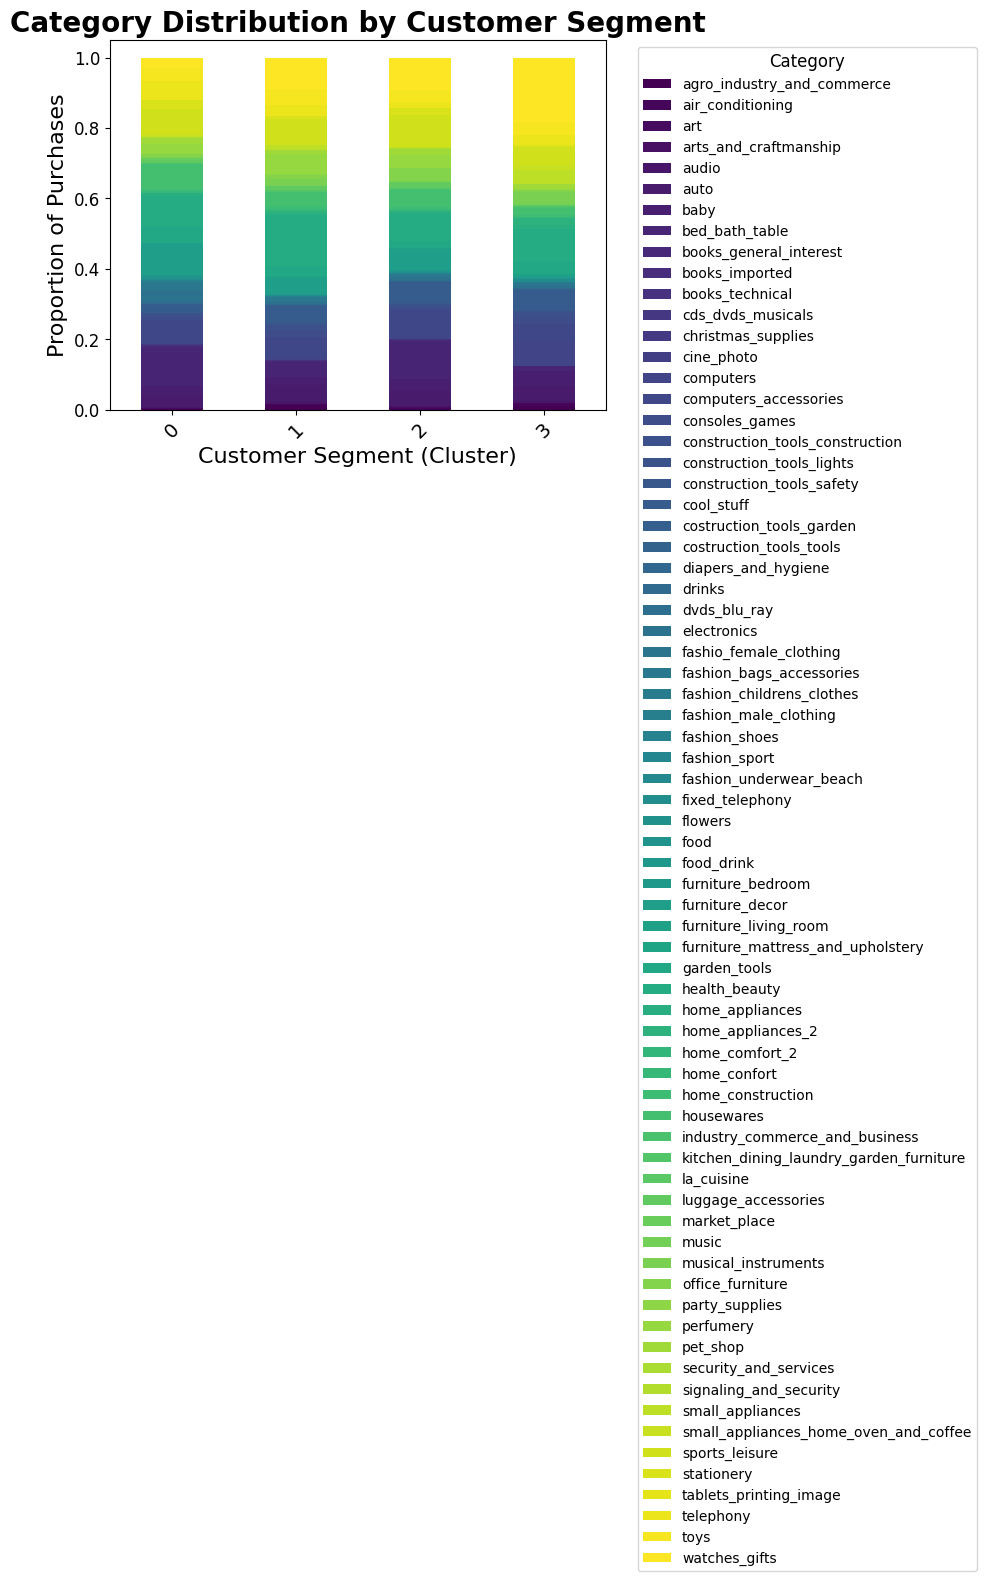


City Distribution by Cluster:

Top 5 cities per cluster:
customer_city  belo horizonte  brasilia  curitiba  porto alegre  \
Cluster                                                           
0                    0.028638  0.021090  0.015481           NaN   
1                    0.025190  0.017721       NaN      0.020797   
2                    0.027243  0.022188  0.015427           NaN   
3                    0.022528  0.023291  0.014891           NaN   

customer_city  rio de janeiro  sao paulo  
Cluster                                   
0                    0.067064   0.163248  
1                    0.070592   0.136497  
2                    0.074572   0.152887  
3                    0.078274   0.131348  


In [27]:
# 8.3. Merge Cluster Labels Back into Original DataFrame (for further analysis)
df_clustered = orders_items_customers.merge(comparison_df[['customer_unique_id', 'Cluster']], 
                                          left_on='customer_unique_id', 
                                          right_on='customer_unique_id', 
                                          how='left')

# Get product information with translation
if ('product_category_name_translation' in dataframes and 
    'olist_products_dataset' in dataframes):
    
    # First merge products dataset to get category names
    df_clustered = df_clustered.merge(
        dataframes['olist_products_dataset'][['product_id', 'product_category_name']],
        on='product_id',
        how='left'
    )
    
    # Then merge with translation
    df_clustered = df_clustered.merge(
        dataframes['product_category_name_translation'],
        on='product_category_name',
        how='left'
    )
    
    # 8.4. Analyze Distributions within Clusters
    print("\nCategory Distribution by Cluster:")
    cat_dist = df_clustered.groupby('Cluster')['product_category_name_english'].value_counts(normalize=True).unstack().fillna(0)
    print(cat_dist)
    
    # Stacked bar plot
    plt.figure(figsize=(12, 8))
    cat_dist.plot(kind='bar', stacked=True, colormap='viridis')
    plt.title('Category Distribution by Customer Segment', fontsize=20, fontweight='bold')
    plt.ylabel('Proportion of Purchases', fontsize=16)
    plt.xlabel('Customer Segment (Cluster)', fontsize=16)
    plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=12)
    plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)
    plt.tight_layout()
    plt.savefig("category_distribution_by_cluster.png", dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Product category translation data not available")

print("\nCity Distribution by Cluster:")
seg_dist = df_clustered.groupby('Cluster')['customer_city'].value_counts(normalize=True).unstack().fillna(0)
top_5_cities = seg_dist.apply(lambda x: x.nlargest(5), axis=1)
print("\nTop 5 cities per cluster:")
print(top_5_cities)

# Add more distribution analyses as needed (e.g., by Region, Payment Type, etc.)

In [28]:
# --- 9. Model Evaluation and Interpretation (If applicable) ---
# (This section would include metrics like silhouette score, cluster profiles, etc.)
# We already did some basic evaluation during the clustering process.

# --- 10. Conclusion and Recommendations ---
# (This would be in your Jupyter Notebook's Markdown cells, summarizing your findings
#  and providing actionable recommendations.)

# --- Optional: Further Analysis ---
# - Time series analysis of customer behavior within each cluster.
# - Predictive modeling (e.g., predicting future CLV).
# - Deeper dive into product categories and customer segments.
# - Analysis by state, city.

# --- Translate product category ---

# Assuming 'dataframes' is a dictionary containing your DataFrames, and
# 'olist_products_dataset' contains the product category names.

# Check if the translation DataFrame and necessary columns exist
if 'product_category_name_translation' in dataframes and 'product_category_name' in dataframes['olist_products_dataset'] and 'product_category_name_english' in dataframes['product_category_name_translation']:
    # Merge the translation DataFrame with the products DataFrame
    dataframes['olist_products_dataset'] = pd.merge(
        dataframes['olist_products_dataset'],
        dataframes['product_category_name_translation'],
        on='product_category_name',
        how='left'
    )

    # Now, merge the translated names into the clustered DataFrame
    df_clustered = pd.merge(
        df_clustered,
        dataframes['olist_products_dataset'][['product_id', 'product_category_name_english']],
        on='product_id',
        how='left'
    )
    print("Product category names translated and merged successfully.")
else:
    print("Translation DataFrame or necessary columns are missing.")

Product category names translated and merged successfully.
